In [22]:
import numpy as np
from numpyro import sample, plate
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax
import jax.random as random
import seaborn as sns
import scipy.signal
import vitaldb
from scipy.signal import find_peaks
from sklearn.decomposition import PCA


import os
from scipy.interpolate import interp1d
from vitaldb import download
from vitaldb import VitalFile
from vitaldb import login




In [2]:
# colorblind friendly palette
from cycler import cycler
cp = ["#172A5A", "#FF7171", "#227567", "#34BAEA", "#F9D466", ]
plt.rcParams['axes.prop_cycle'] = cycler(color=cp)

# set default font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Open Sans', 'Arial']

# automatically despine
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# set defualt DPI
plt.rcParams['figure.dpi'] = 72

In [3]:
track_names = ['ECG_II', 'ART', 'PLETH']
caseids = vitaldb.find_cases(track_names)
cid = caseids[0]

print('tracks:', track_names)
print('found', len(caseids), 'case ids')
print('case id:', cid)

vf = vitaldb.VitalFile(cid, track_names)

fs = 100
data = vf.to_numpy(track_names, 1/fs)
t = np.arange(data.shape[0]) / fs

ecg = data[:,0]
art = data[:,1]
ppg = data[:,2]

tracks: ['ECG_II', 'ART', 'PLETH']
found 3458 case ids
case id: 1


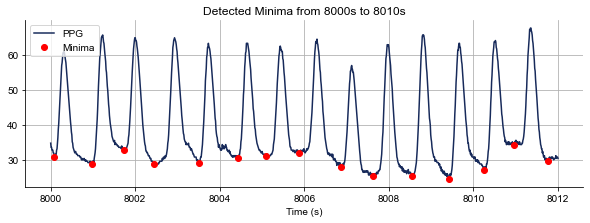

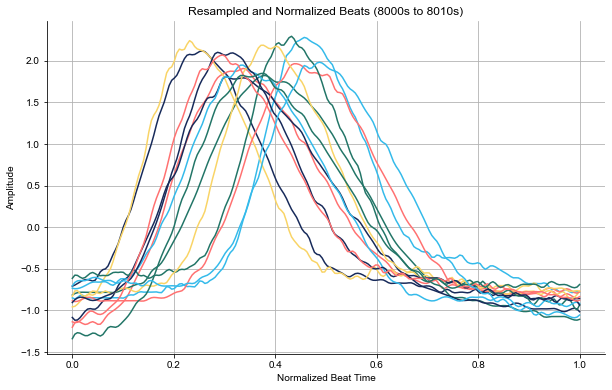

In [40]:
# Slice time and PPG data
mask = (t >= 8000) & (t <= 8012)
t_window = t[mask]
ppg_window = ppg[mask]

# Invert signal to find minima
minima_indices, _ = find_peaks(-ppg_window, distance=50)  # tweak distance if needed
minima_times = t_window[minima_indices]

# Plot detected minima for confirmation
plt.figure(figsize=(10, 3))
plt.plot(t_window, ppg_window, label='PPG')
plt.plot(minima_times, ppg_window[minima_indices], 'ro', label='Minima')
plt.title("Detected Minima from 8000s to 8010s")
plt.xlabel("Time (s)")
plt.legend()
plt.grid()
plt.show()

# Extract and normalize each beat
resampled_beats = []
resample_len = 200

for i in range(len(minima_indices) - 1):
    idx_start = minima_indices[i]
    idx_end = minima_indices[i + 1]

    beat_t = t_window[idx_start:idx_end]
    beat_ppg = ppg_window[idx_start:idx_end]

    if len(beat_ppg) < 5:
        continue  # skip too-short segments

    # Interpolate and resample to uniform length
    interp_fn = interp1d(beat_t, beat_ppg, kind='cubic')
    t_uniform = np.linspace(beat_t[0], beat_t[-1], resample_len)
    resampled = interp_fn(t_uniform)
    normalized = (resampled - np.mean(resampled)) / np.std(resampled)
    resampled_beats.append(normalized)

# Convert to array
resampled_beats = np.array(resampled_beats)

# Plot all beats
plt.figure(figsize=(10, 6))
for i, beat in enumerate(resampled_beats):
    plt.plot(np.linspace(0, 1, resample_len), beat, label=f"Beat {i+1}")
plt.title("Resampled and Normalized Beats (8000s to 8010s)")
plt.xlabel("Normalized Beat Time")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

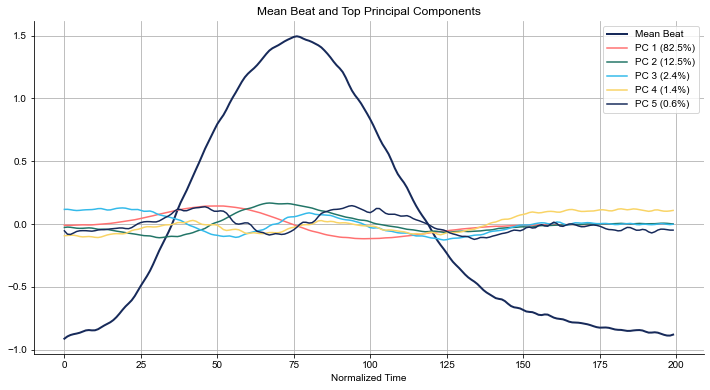

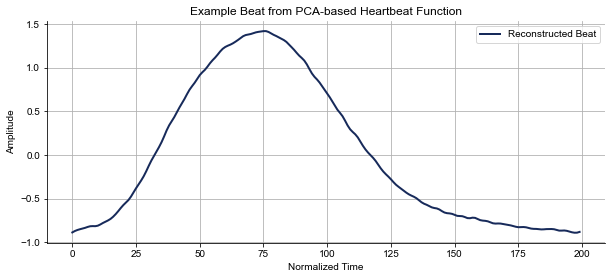

In [36]:

# Run PCA
pca = PCA(n_components=5)
pca.fit(resampled_beats)

# Mean beat
mean_beat = pca.mean_

# Top principal components (basis shapes)
components = pca.components_

# Explained variance
explained = pca.explained_variance_ratio_

# Plot mean + top 3 components
plt.figure(figsize=(12, 6))
plt.plot(mean_beat, label="Mean Beat", linewidth=2)
for i in range(5):
    plt.plot(components[i], label=f"PC {i+1} ({explained[i]*100:.1f}%)")
plt.title("Mean Beat and Top Principal Components")
plt.xlabel("Normalized Time")
plt.legend()
plt.grid()
plt.show()

# === Function to reconstruct a beat ===
def heartbeat_fn(t_normalized, coeffs):
    """
    Reconstructs a beat using top PCs.
    t_normalized: array from 0 to 1 (len=200)
    coeffs: list of len <= num PCs
    """
    reconstruction = mean_beat.copy()
    for i, c in enumerate(coeffs):
        reconstruction += c * components[i]
    return reconstruction

# === Example: reconstruct a beat with just 3 PCs ===
example_coeffs = [1.0, -0.5, 0.2]
reconstructed_beat = heartbeat_fn(np.linspace(0, 1, 200), example_coeffs)

# Plot reconstruction
plt.figure(figsize=(10, 4))
plt.plot(reconstructed_beat, label="Reconstructed Beat", linewidth=2)
plt.title("Example Beat from PCA-based Heartbeat Function")
plt.xlabel("Normalized Time")
plt.ylabel("Amplitude")
plt.grid()
plt.legend()
plt.show()
